### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime  
from statsmodels.tsa.api import VAR, ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import math

%matplotlib inline
#plot size
plt.rcParams['figure.figsize'] = (20,10)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_path = Path().resolve().parent/'datasets/bike_sharing_hourly/bike_sharing_hourly.csv'
df = pd.read_csv(dataset_path)
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [3]:
#check unique column
df.columns.unique()

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [4]:
df['dteday'] = pd.to_datetime(df['dteday'])
df.dteday.describe()

count                   17379
unique                    731
top       2012-08-29 00:00:00
freq                       24
first     2011-01-01 00:00:00
last      2012-12-31 00:00:00
Name: dteday, dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [6]:
#check missing value
df.isnull().values.any()

False

In [7]:
#Check the total number of days for 2 years
unique_day = 731
total_hr_per_day = 24
new_total_instances = unique_day*total_hr_per_day
print(new_total_instances)

17544


From the output, the count for 'dteday' is 731. Which means there will be 17544 instances

In [8]:
hourly_data = pd.date_range('2011-01-01', periods = new_total_instances, freq = 'H')
hourly_data = pd.DataFrame(hourly_data)
hourly_data.columns = ['datetime']
hourly_data

,datetime
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00
...,...
17539,2012-12-31 19:00:00
17540,2012-12-31 20:00:00
17541,2012-12-31 21:00:00
17542,2012-12-31 22:00:00


In [9]:
#Create new columns for year, month, day and hour for the dataframe
df['year'] = df['dteday'].dt.year
df['month'] = df['dteday'].dt.month
df['day'] = df['dteday'].dt.day
df['hour'] = df['hr']
df.tail(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,atemp,hum,windspeed,casual,registered,cnt,year,month,day,hour
17369,17370,2012-12-31,1,1,12,14,0,1,1,2,...,0.2727,0.45,0.2239,62,185,247,2012,12,31,14
17370,17371,2012-12-31,1,1,12,15,0,1,1,2,...,0.2879,0.45,0.1343,69,246,315,2012,12,31,15
17371,17372,2012-12-31,1,1,12,16,0,1,1,2,...,0.2576,0.48,0.1940,30,184,214,2012,12,31,16
17372,17373,2012-12-31,1,1,12,17,0,1,1,2,...,0.2879,0.48,0.0896,14,150,164,2012,12,31,17
17373,17374,2012-12-31,1,1,12,18,0,1,1,2,...,0.2727,0.48,0.1343,10,112,122,2012,12,31,18
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,0.2576,0.60,0.1642,11,108,119,2012,12,31,19
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,0.2576,0.60,0.1642,8,81,89,2012,12,31,20
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,0.2576,0.60,0.1642,7,83,90,2012,12,31,21
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,0.2727,0.56,0.1343,13,48,61,2012,12,31,22
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,...,0.2727,0.65,0.1343,12,37,49,2012,12,31,23


In [10]:
# Concat new dataframe into 'datetime' and remove unnecesarry columns
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day','hour']])
df = df.drop(['instant' ,'dteday', 'yr','mnth','hr','year', 'month', 'day','hour'], axis = 1)
df

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
0,1,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,2011-01-01 00:00:00
1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,2011-01-01 01:00:00
2,1,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,2011-01-01 02:00:00
3,1,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,2011-01-01 03:00:00
4,1,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,2011-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,2012-12-31 19:00:00
17375,1,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,2012-12-31 20:00:00
17376,1,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,2012-12-31 21:00:00
17377,1,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,2012-12-31 22:00:00


In [11]:
# Merge the missing timestamp onto dataframe
df_new = pd.merge(df,hourly_data,on='datetime',how='outer')
df_new

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0,2011-01-01 00:00:00
1,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0,2011-01-01 01:00:00
2,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0,2011-01-01 02:00:00
3,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0,2011-01-01 03:00:00
4,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0,2011-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-30 12:00:00
17540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-08 03:00:00
17541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-29 03:00:00
17542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-12-24 04:00:00


In [12]:
df_new = df_new.sort_values(by="datetime")
df_new

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0,2011-01-01 00:00:00
1,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0,2011-01-01 01:00:00
2,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,5.0,27.0,32.0,2011-01-01 02:00:00
3,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0,2011-01-01 03:00:00
4,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0,2011-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,11.0,108.0,119.0,2012-12-31 19:00:00
17375,1.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,8.0,81.0,89.0,2012-12-31 20:00:00
17376,1.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642,7.0,83.0,90.0,2012-12-31 21:00:00
17377,1.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343,13.0,48.0,61.0,2012-12-31 22:00:00


In [13]:
df_new.datetime.describe(datetime_is_numeric=True)

count                  17544
mean     2012-01-01 11:30:00
min      2011-01-01 00:00:00
25%      2011-07-02 17:45:00
50%      2012-01-01 11:30:00
75%      2012-07-02 05:15:00
max      2012-12-31 23:00:00
Name: datetime, dtype: object

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17544 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   season      17379 non-null  float64       
 1   holiday     17379 non-null  float64       
 2   weekday     17379 non-null  float64       
 3   workingday  17379 non-null  float64       
 4   weathersit  17379 non-null  float64       
 5   temp        17379 non-null  float64       
 6   atemp       17379 non-null  float64       
 7   hum         17379 non-null  float64       
 8   windspeed   17379 non-null  float64       
 9   casual      17379 non-null  float64       
 10  registered  17379 non-null  float64       
 11  cnt         17379 non-null  float64       
 12  datetime    17544 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(12)
memory usage: 1.9 MB


In [15]:
# Check for missing value on full date time
df_new.isna().sum()

season        165
holiday       165
weekday       165
workingday    165
weathersit    165
temp          165
atemp         165
hum           165
windspeed     165
casual        165
registered    165
cnt           165
datetime        0
dtype: int64

### Data Cleaning

In [16]:
# Perform imputation to fill NaN value
# Use linear interpolation to fill up nulls
df_clean = df_new.interpolate(method='pad', axis=0)
df_clean

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0,2011-01-01 00:00:00
1,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0,2011-01-01 01:00:00
2,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,5.0,27.0,32.0,2011-01-01 02:00:00
3,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0,2011-01-01 03:00:00
4,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0,2011-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,11.0,108.0,119.0,2012-12-31 19:00:00
17375,1.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,8.0,81.0,89.0,2012-12-31 20:00:00
17376,1.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642,7.0,83.0,90.0,2012-12-31 21:00:00
17377,1.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343,13.0,48.0,61.0,2012-12-31 22:00:00


In [17]:
df_clean.datetime.describe()

count                   17544
unique                  17544
top       2011-02-24 22:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-31 23:00:00
Name: datetime, dtype: object

In [18]:
df_clean.set_index("datetime", drop=True, inplace=True)
df_clean.index.name = None
df_clean

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
2011-01-01 00:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0
2011-01-01 01:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0
2011-01-01 02:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,5.0,27.0,32.0
2011-01-01 03:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0
2011-01-01 04:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,11.0,108.0,119.0
2012-12-31 20:00:00,1.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,8.0,81.0,89.0
2012-12-31 21:00:00,1.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642,7.0,83.0,90.0
2012-12-31 22:00:00,1.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343,13.0,48.0,61.0


### Visualization

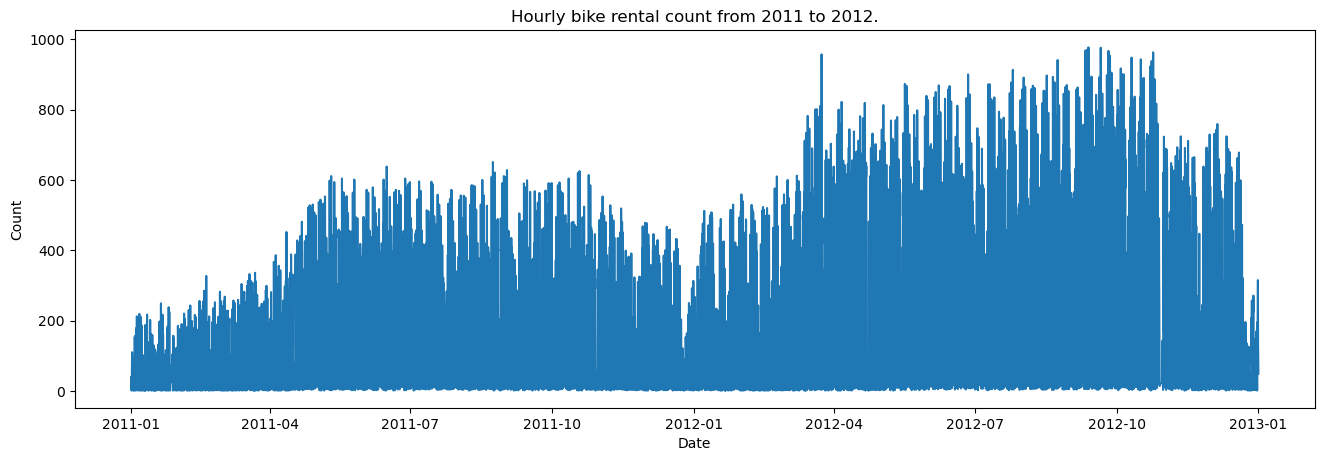

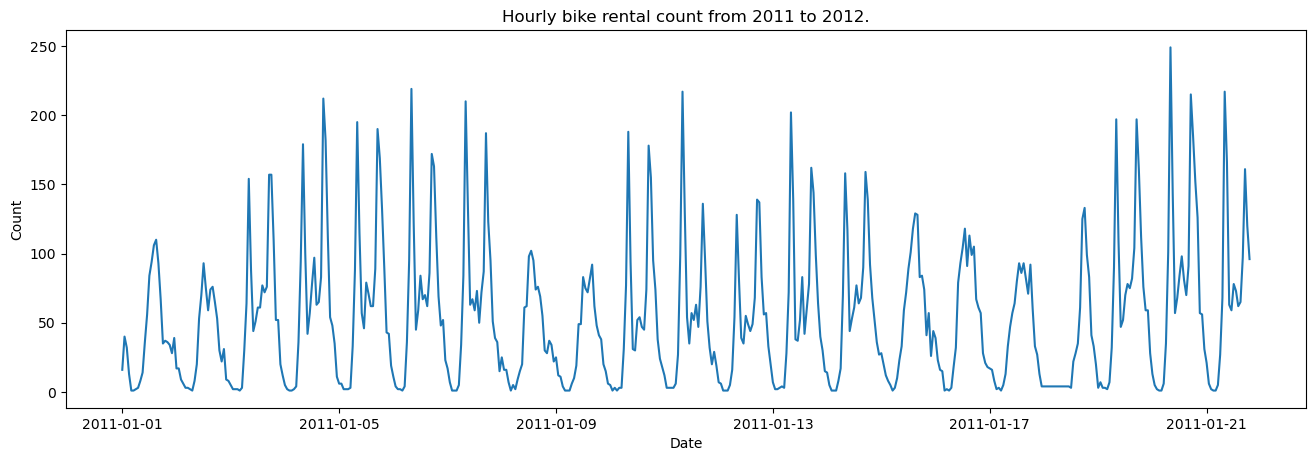

In [19]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Count', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df, x=df_clean.index, y=df_clean['cnt'], title='Hourly bike rental count from 2011 to 2012.');
plot_df(df, x=df_clean.iloc[:500].index, y=df_clean['cnt'].iloc[:500], title='Hourly bike rental count from 2011 to 2012.');

#### Decomposition

<Figure size 1440x720 with 0 Axes>

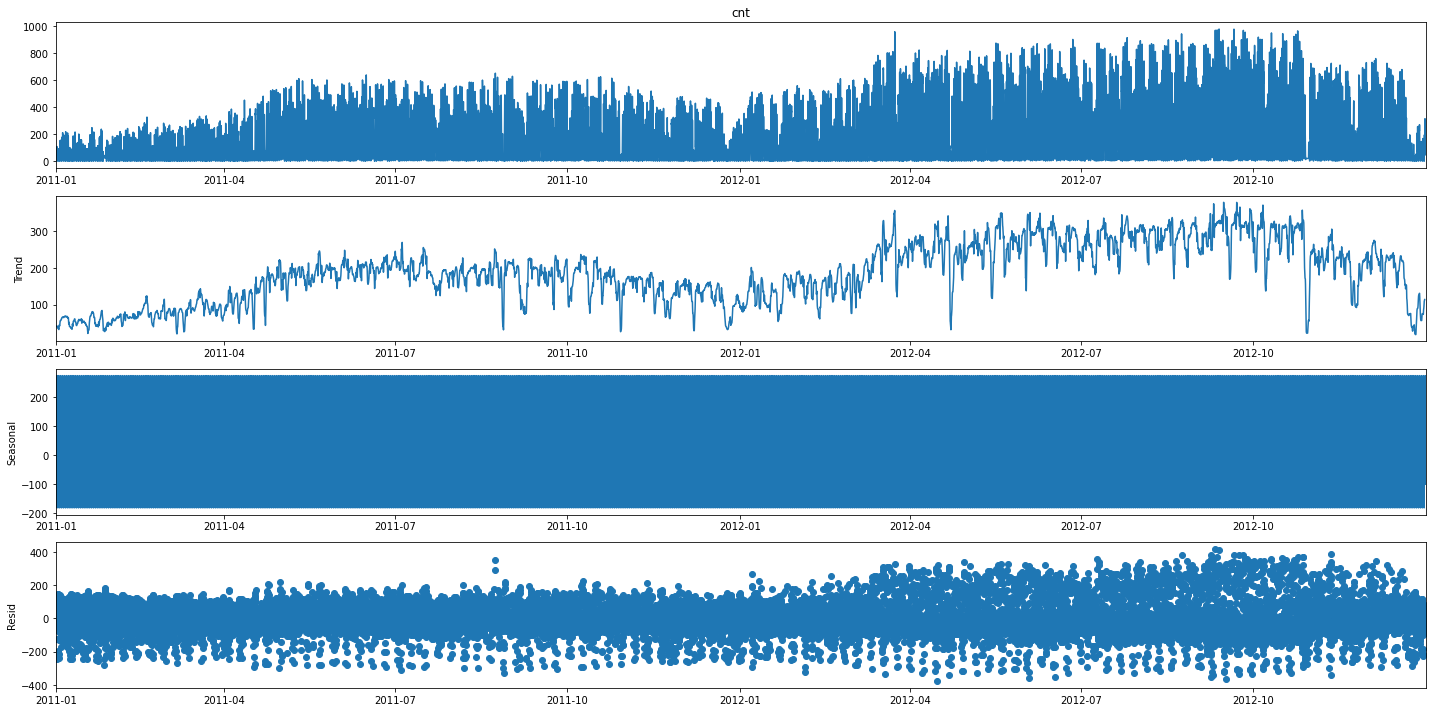

In [20]:
# perform decomposition for whole data
plt.figure(figsize=(20,10))
result = seasonal_decompose(df_clean.cnt, model='additive')
result.plot()
plt.show()

<Figure size 1440x720 with 0 Axes>

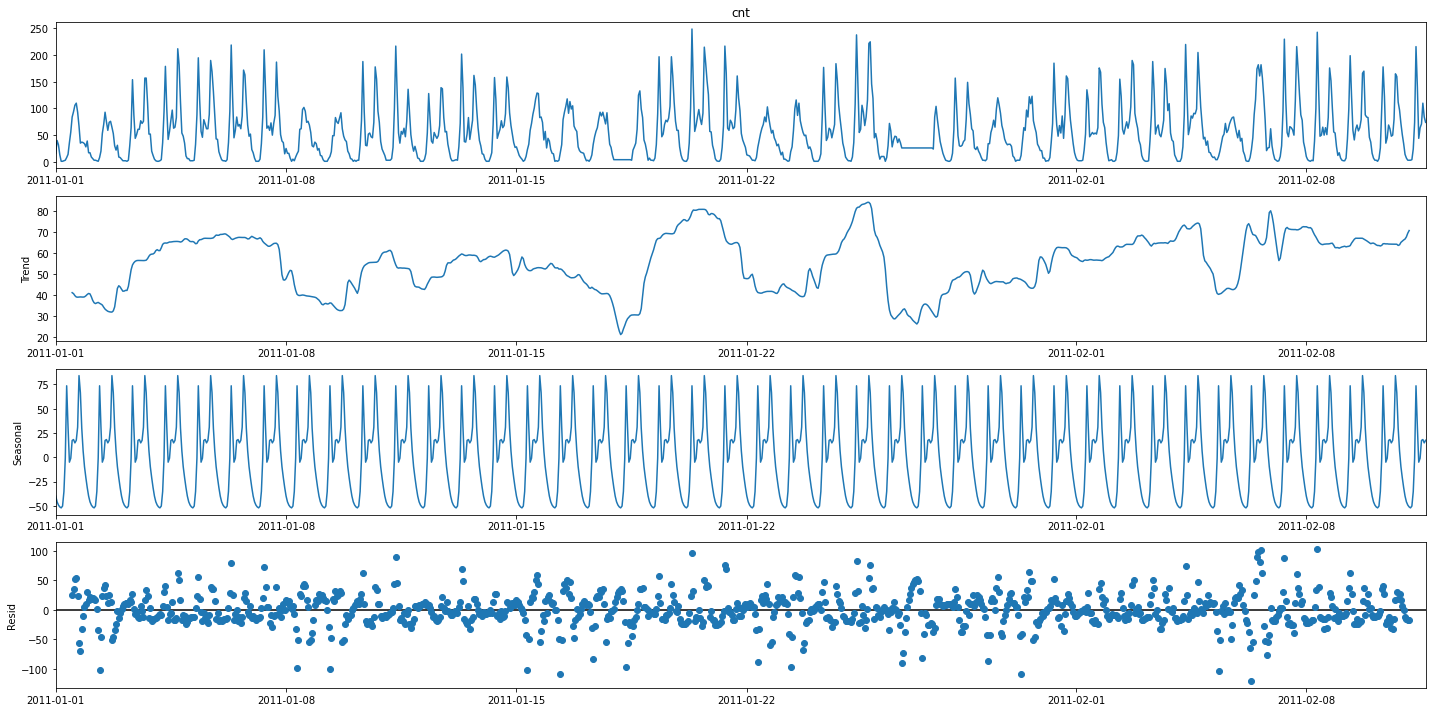

In [21]:
# perform decomposition for first 300 data
plt.figure(figsize=(20,10))
result = seasonal_decompose(df_clean.cnt.iloc[:1000], model='additive')
result.plot()
plt.show()

<Figure size 1440x720 with 0 Axes>

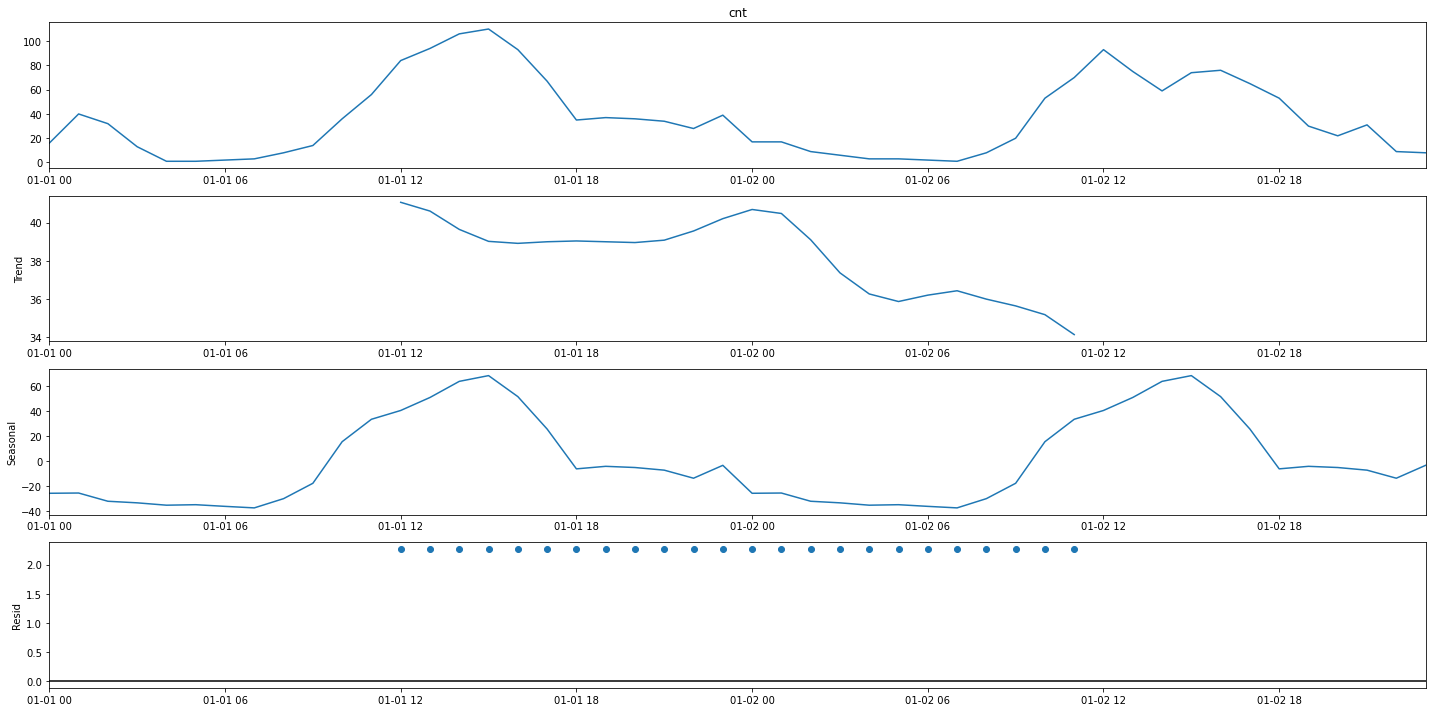

In [22]:
# perform decomposition for first 48 data
plt.figure(figsize=(20,10))
result = seasonal_decompose(df_clean.cnt.iloc[:48], model='additive')
result.plot()
plt.show()

From the decomposition, the seasonal is stable along the time. This proved it is an additive model.

### Model Preparation

In [23]:
df_model = pd.Series(df_clean.cnt.values, index=df_clean.index)
df_model

2011-01-01 00:00:00     16.0
2011-01-01 01:00:00     40.0
2011-01-01 02:00:00     32.0
2011-01-01 03:00:00     13.0
2011-01-01 04:00:00      1.0
                       ...  
2012-12-31 19:00:00    119.0
2012-12-31 20:00:00     89.0
2012-12-31 21:00:00     90.0
2012-12-31 22:00:00     61.0
2012-12-31 23:00:00     49.0
Length: 17544, dtype: float64

In [24]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
result = adfuller(df_model)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.025595e+00
P-Value                 6.376893e-10
# Lags Used             4.200000e+01
# Observations Used     1.750100e+04
Critical Value (1%)    -3.430724e+00
Critical Value (5%)    -2.861705e+00
Critical Value (10%)   -2.566858e+00
dtype: float64


It is stationary when the P value is less than 0.05

#### Split Train and Test

In [25]:
split_ratio = round(df_model.shape[0]*0.8)
train_use = df_model.iloc[:split_ratio]
test_use = df_model.iloc[split_ratio:]
test_use.isnull().values.any()

False

In [26]:
train_use = df_model.iloc[:split_ratio]
test_use = df_model.iloc[split_ratio:]
print(f'train: {train_use.shape} test: {test_use.shape}')

train: (14035,) test: (3509,)


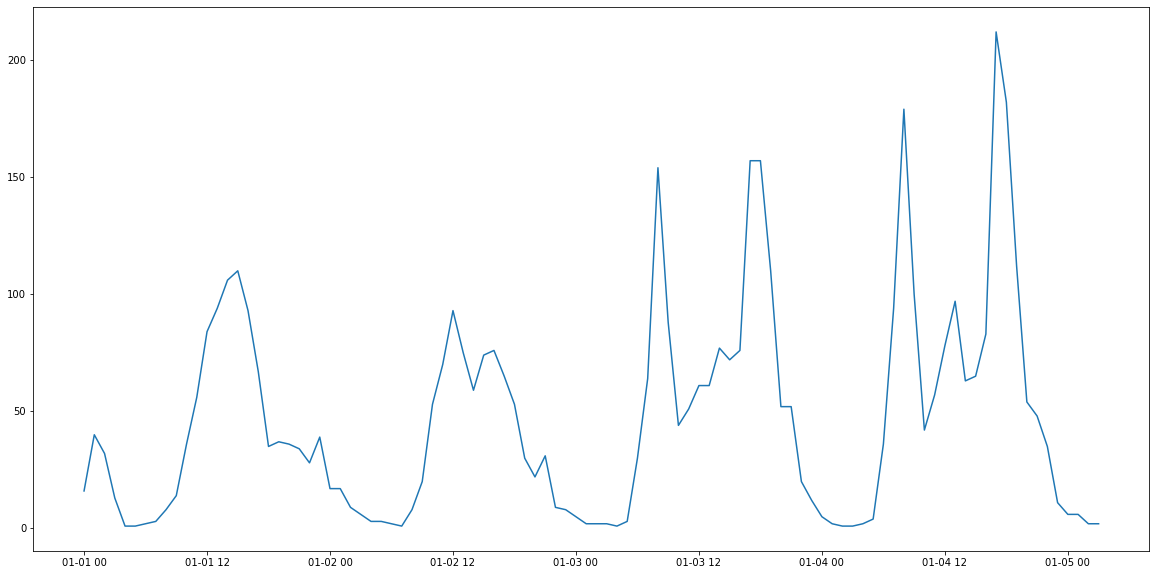

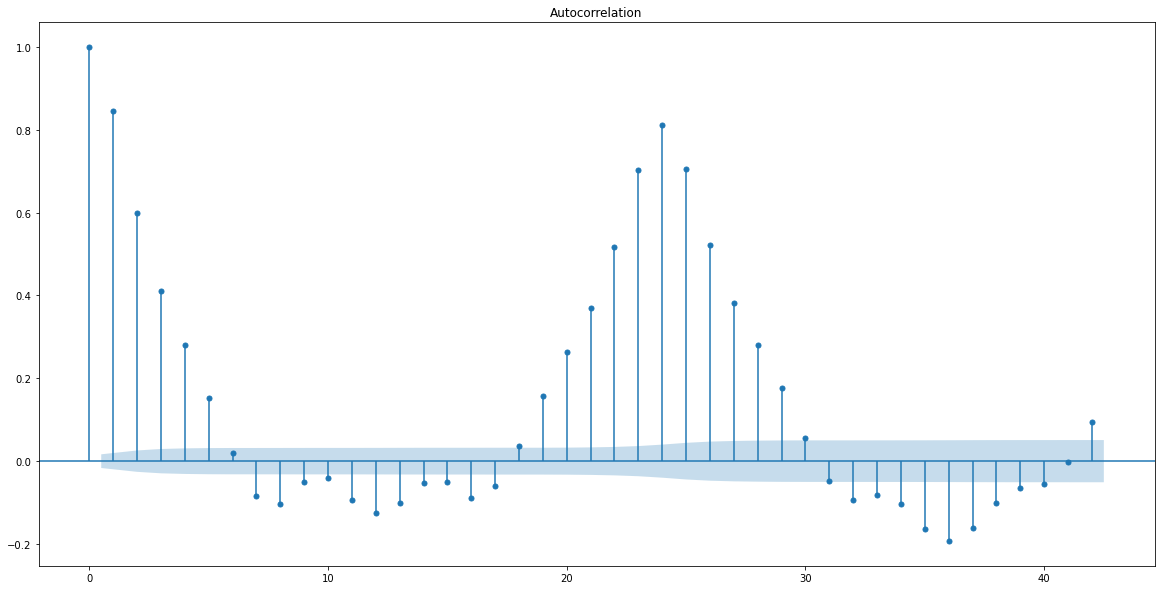

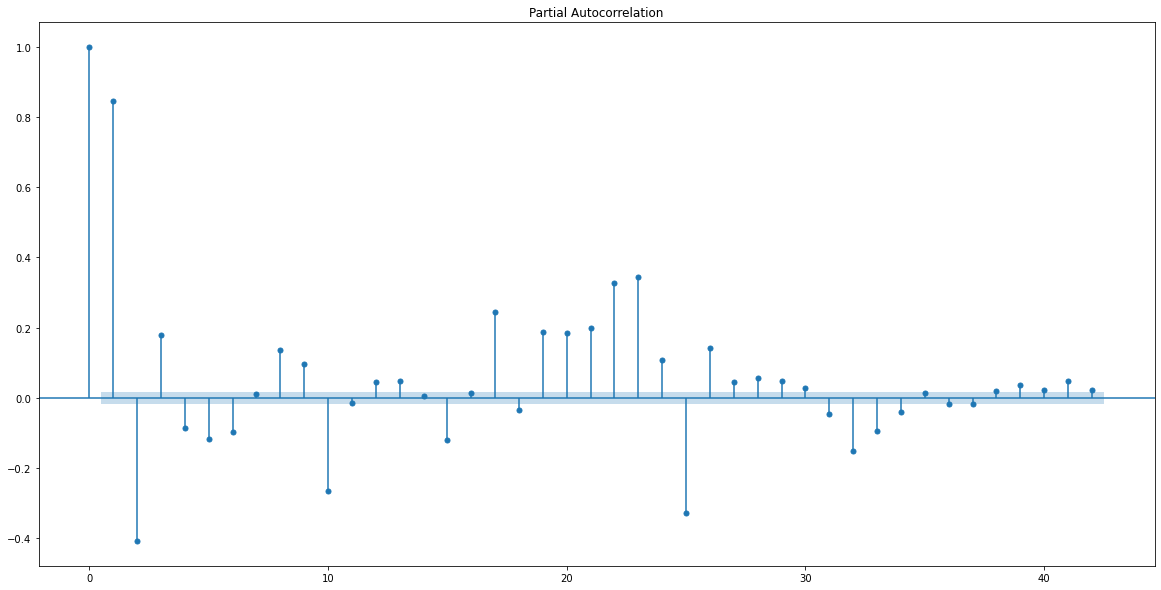

In [27]:
#plot acf and pacf
plt.plot(train_use.iloc[:100])
plot_acf(train_use);
plot_pacf(train_use);

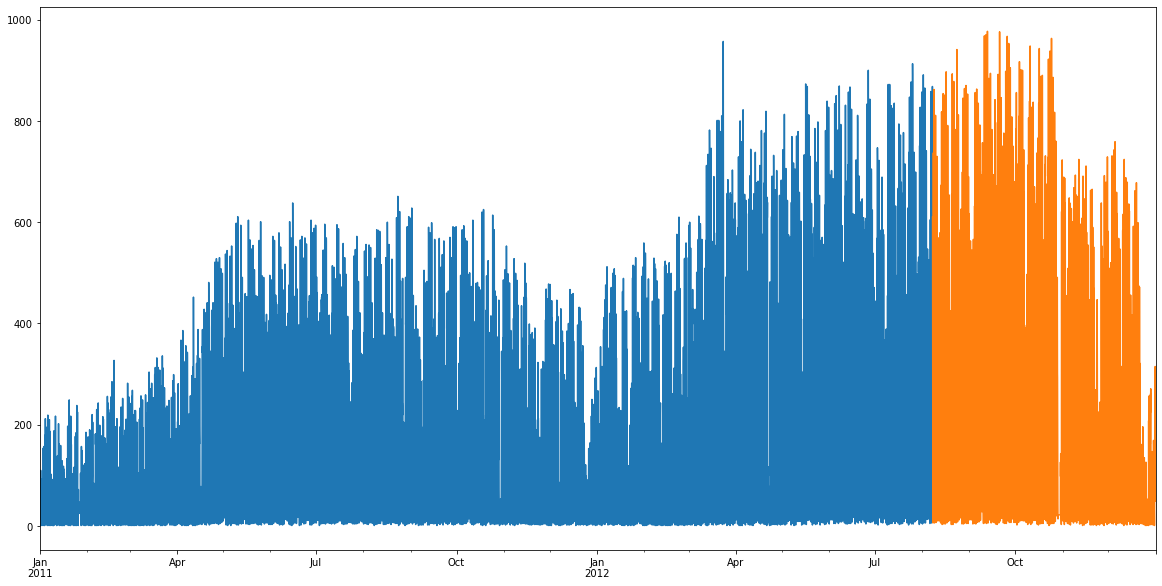

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
train_use.plot(ax=ax)
test_use.plot(ax=ax)
plt.show()

### Forecast Method: Holt's Winter

In [29]:
fit = ExponentialSmoothing(train_use, seasonal_periods=24, trend='mul',seasonal='add').fit()
fcast = fit.forecast(split_ratio).rename("Holt-Winters")

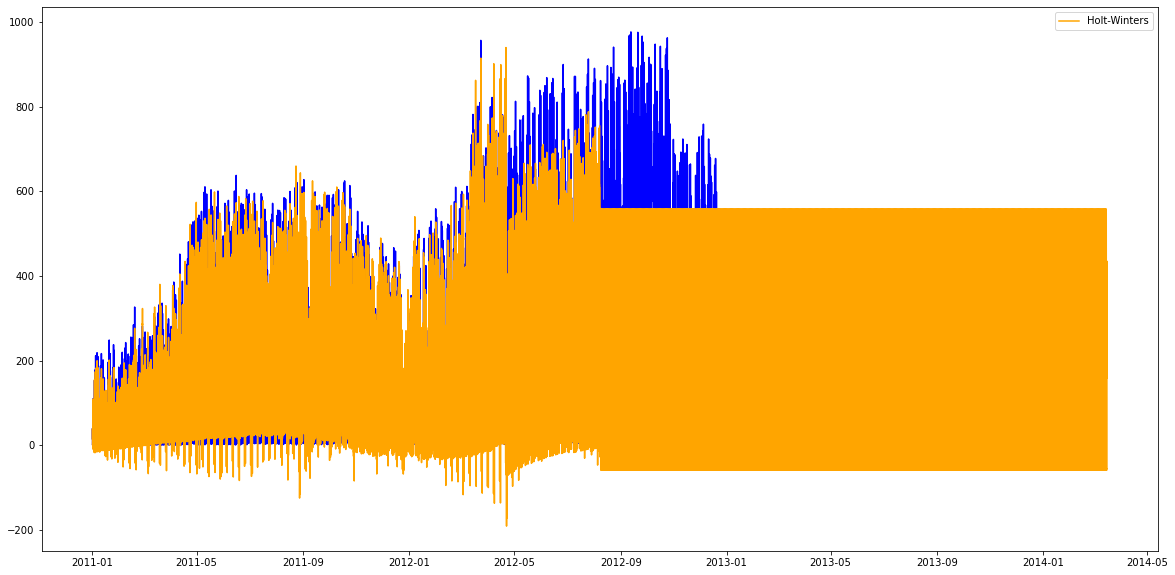

In [30]:
#plot graph
plt.plot(train_use[:-100],color='blue')
plt.plot(test_use,color='blue')

plt.plot(fit.fittedvalues, color='orange')
line1, = plt.plot(fcast,color='orange')

plt.legend([line1], [fcast.name])

### Model Validation

In [31]:
#create rmse function
def rmse(predicted_val, true):
    return np.sqrt(np.mean((predicted_val - true)**2))

In [32]:
# Model - multiplicative trend, additive seasonality
train_error = rmse(fit.fittedvalues, train_use)
test_error = rmse(fcast, test_use)
print("Holt-Winters (multiplicative trend, additive seasonality)")
print(f"Training set error: {train_error}, Test set error: {test_error}")

Holt-Winters (multiplicative trend, additive seasonality)
Training set error: 70.7199047003943, Test set error: 161.8932143783836


### Model Prediction

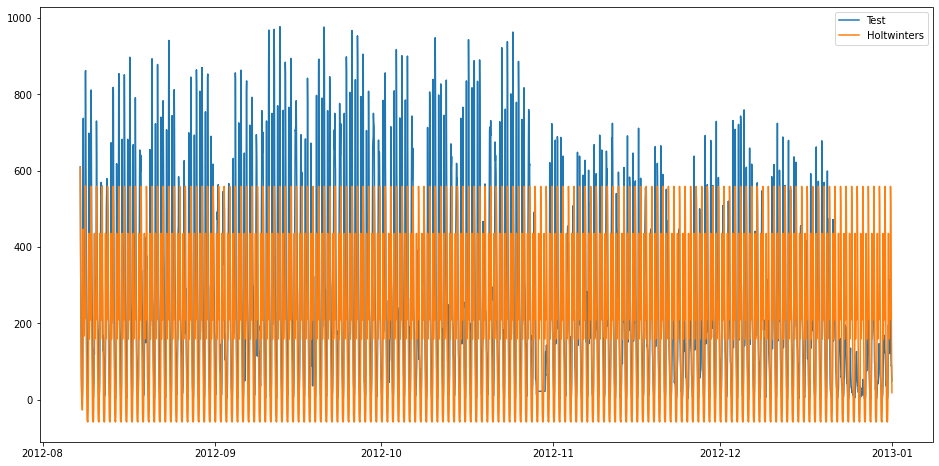

In [33]:
# make prediction
y = fit.forecast(split_ratio)
y_predicted=pd.DataFrame(y,index=test_use.index,columns=['Holt-Winters'])

plt.figure(figsize=(16,8))
plt.plot(test_use, label='Test')
plt.plot(y_predicted, label='Holtwinters')
plt.legend(loc='best')
plt.show()

### Model Evaluation

In [34]:
#model evaluation
print(f'Mean Absolute Error = {mean_absolute_error(test_use,y_predicted)}')
print(f'Mean Squared Error = {mean_squared_error(test_use,y_predicted)}')
print(f'Root Mean Squared Error = {math.sqrt(mean_squared_error(test_use,y_predicted))}')

Mean Absolute Error = 123.69728338326037
Mean Squared Error = 26209.41286176527
Root Mean Squared Error = 161.8932143783836
